---

***Filename***: main.ipynb

---

***Description***: This notebook builds, trains and tests the neural network model

---

***Author***: Alexandros Iliadis

***Project***: RANDrumizer

***Date***: June 2024

---

## Preliminaries

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change Directory
import os
cwd = '/content/gdrive/My Drive/Colab/MSc/Applied Machine Learning for Sound and Music/Project'
os.chdir(cwd)

In [ ]:
# Install Modules
!pip install torchinfo
!pip install torchview

In [ ]:
# Import Modules
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [ ]:
# Load Data
import pickle
with open(os.path.join(cwd,'Files','dataset.pickle'),'rb') as file:
    data = pickle.load(file)
print(data['MEASURES'],'\n')
print(data['ONSETS'].droplevel('TICKS'))

          START_SEC     END_SEC START_TICKS END_TICKS  BPM    USPB NUM DEN
ID  BAR                                                                   
1   1             0    3.243243           0      1920   74  810810   4   4
    2      3.243243    6.486486        1920      3840   74  810810   4   4
    3      6.486486     9.72973        3840      5760   74  810810   4   4
    4       9.72973   12.972973        5760      7680   74  810810   4   4
    5     12.972973   16.216216        7680      9600   74  810810   4   4
...             ...         ...         ...       ...  ...     ...  ..  ..
150 71        160.0  162.285714      134400    136320  105  571428   4   4
    72   162.285714  164.571429      136320    138240  105  571428   4   4
    73   164.571429  166.857143      138240    140160  105  571428   4   4
    74   166.857143  169.142857      140160    142080  105  571428   4   4
    75   169.142857  171.428571      142080    144000  105  571428   4   4

[24774 rows x 8 columns]

In [ ]:
# Create Dataset
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self,data):

        self.ids = []
        self.bars = []
        self.onsets = []

        ids = data['MEASURES'].index.get_level_values('ID').unique().values.tolist()
        for id in ids:
            bars = data['MEASURES'].loc[id].index.get_level_values('BAR').values
            for bar in bars:
                if np.array_equal(data['MEASURES'].loc[id,bar][['NUM','DEN']].values,np.array([4,4])) == True:
                    onsets = data['ONSETS'].loc[id,bar].to_numpy(dtype = int)
                    onsets = np.hstack((np.zeros((onsets.shape[0],1)),onsets))
                    onsets = np.vstack((np.zeros((1,onsets.shape[1])),onsets))
                    onsets[0,0] = 1
                    self.ids.append(id)
                    self.bars.append(bar)
                    self.onsets.append(onsets)

        self.ids = np.array(self.ids)
        self.bars = np.array(self.bars)
        self.onsets = np.array(self.onsets)
        self.unique_ids,self.counts = np.unique(self.ids,return_counts = True)
        self.parts = [part.replace('_',' ') for part in data['ONSETS'].columns.tolist()]

    def __len__(self):
        return self.onsets.shape[0]

    def __getitem__(self,index):
        return self.onsets[index,:,:],self.ids[index],self.bars[index]

    def shuffle(self):

        indices = np.arange(len(self.unique_ids))
        np.random.shuffle(indices)
        self.unique_ids = self.unique_ids[indices]
        self.counts = self.counts[indices]

        shuffling = []
        for id,count in zip(self.unique_ids,self.counts):
            index = np.where(self.ids == id)[0][0]
            shuffling.append(np.arange(index,index + count))
        shuffling = np.concatenate(shuffling)

        self.ids = self.ids[shuffling]
        self.bars = self.bars[shuffling]
        self.onsets = self.onsets[shuffling,:,:]

dataset = CustomDataset(data)

In [ ]:
# Split Dataset
from torch.utils.data import Subset

train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

dataset_size = len(dataset)
train_size = round(train_ratio*dataset_size)
valid_size = round(valid_ratio*dataset_size)
test_size = round(test_ratio*dataset_size)

total_size = train_size + valid_size + test_size
while total_size != dataset_size:
    if total_size < dataset_size:
        train_size += 1
    elif total_size > dataset_size:
        train_size -= 1
    total_size = train_size + valid_size + test_size

train_indices = np.array([],dtype = int)
valid_indices = np.array([],dtype = int)
test_indices = np.array([],dtype = int)

dataset.shuffle()
for id in dataset.unique_ids:
    if len(train_indices) < train_size:
        indices = np.where(dataset.ids == id)[0]
        train_indices = np.append(train_indices,indices)
        continue
    if len(valid_indices) < valid_size:
        indices = np.where(dataset.ids == id)[0]
        valid_indices = np.append(valid_indices,indices)
        continue
    if len(test_indices) < test_size:
        indices = np.where(dataset.ids == id)[0]
        test_indices = np.append(test_indices,indices)
        continue

train_set = Subset(dataset,train_indices)
valid_set = Subset(dataset,valid_indices)
test_set = Subset(dataset,test_indices)

In [ ]:
# Prepare Dataset
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset = train_set,batch_size = batch_size,shuffle = False)
valid_loader = DataLoader(dataset = valid_set,batch_size = batch_size,shuffle = False)
test_loader = DataLoader(dataset = test_set,batch_size = batch_size,shuffle = False)

## Build Model

#### Encoder

In [ ]:
# Encoder Class
import torch.nn as nn
from torchinfo import summary
class Encoder(nn.Module):
    def __init__(self,input_size,latent_size = 2,hidden_sizes = [],num_of_lstm_layers = 2,num_of_lstm_units = 256,bidirectional = False,dropout = 0,slope = 0):
        super().__init__()

        if bidirectional == False:
            self.num_of_directions = 1
        elif bidirectional == True:
            self.num_of_directions = 2

        if isinstance(hidden_sizes,int):
            hidden_sizes = [hidden_sizes]

        self.input_size = input_size

        self.lstm_layers = nn.LSTM(input_size = input_size,hidden_size = num_of_lstm_units,num_layers = num_of_lstm_layers,bidirectional = bidirectional,dropout = 0 if num_of_lstm_layers == 1 else dropout,batch_first = True)

        num_of_linear_layers = len(hidden_sizes)
        linear_layer_sizes = [self.num_of_directions*num_of_lstm_layers*num_of_lstm_units]
        linear_layer_sizes.extend(hidden_sizes)
        self.linear_layers = nn.ModuleList([nn.Linear(linear_layer_sizes[index],linear_layer_sizes[index + 1]) for index in range(num_of_linear_layers)])

        self.mu_layer = nn.Linear(linear_layer_sizes[-1],latent_size)
        self.var_layer = nn.Linear(linear_layer_sizes[-1],latent_size)

        self.dropout = nn.Dropout(dropout)
        self.hidden_activation = nn.LeakyReLU(slope)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,x):
        _,(h,_) = self.lstm_layers(x)
        h = h.reshape((h.shape[1],-1))
        h = self.dropout(h)
        h = self.hidden_activation(h)
        for linear_layer in self.linear_layers:
            h = linear_layer(h)
            h = self.dropout(h)
            h = self.hidden_activation(h)
        mu = self.mu_layer(h)
        log_var = self.var_layer(h)
        return mu,log_var

    def summary(self,batch_size,sequence_length):
        print(summary(self,(batch_size,sequence_length,self.input_size)))

    def __repr__(self):
        repr = super().__repr__()
        repr = repr.replace(', ',',')
        repr = repr.replace('=',' = ')
        repr = repr.replace('\n  )','\n  }')
        repr = repr.replace('ModuleList()','ModuleList[]')
        repr = repr.replace('ModuleList(','ModuleList\n  [')
        repr = repr.replace('(\n','\n{\n')
        repr = repr.replace('\n)','\n}')
        repr = repr.replace(')\n  }',')\n  ]')
        return repr

In [ ]:
# Build Encoder
input_size = dataset.onsets.shape[2]
latent_size = 64
hidden_sizes = []
num_of_lstm_layers = 1
num_of_lstm_units = 256
bidirectional = True
dropout = 0.3
slope = 0.1
encoder = Encoder(input_size,latent_size,hidden_sizes,num_of_lstm_layers,num_of_lstm_units,bidirectional,dropout,slope)
print(encoder)
sequence_length = dataset.onsets.shape[1]
encoder.summary(batch_size,sequence_length)

Encoder
{
  (lstm_layers): LSTM(10,256,batch_first = True,bidirectional = True)
  (linear_layers): ModuleList[]
  (mu_layer): Linear(in_features = 512,out_features = 64,bias = True)
  (var_layer): Linear(in_features = 512,out_features = 64,bias = True)
  (dropout): Dropout(p = 0.3,inplace = False)
  (hidden_activation): LeakyReLU(negative_slope = 0.1)
}
Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [128, 64]                 --
├─LSTM: 1-1                              [128, 49, 512]            548,864
├─Dropout: 1-2                           [128, 512]                --
├─LeakyReLU: 1-3                         [128, 512]                --
├─Linear: 1-4                            [128, 64]                 32,832
├─Linear: 1-5                            [128, 64]                 32,832
Total params: 614,528
Trainable params: 614,528
Non-trainable params: 0
Total mult-adds (G): 3.45
Input size (MB): 0.25
Forward/backward

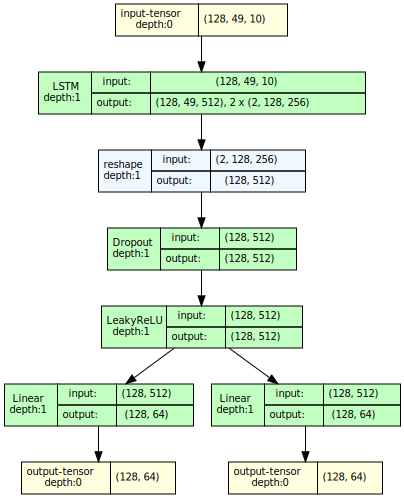

In [ ]:
# Visualize Encoder
from torchview import draw_graph
encoder_graph = draw_graph(encoder,input_size = (batch_size,sequence_length,input_size),save_graph = True,directory = './Files',filename = 'encoder')
encoder_graph.resize_graph(scale = 2)
encoder_graph.visual_graph

#### Decoder

In [ ]:
# Decoder Class
import torch.nn as nn
from torchinfo import summary
class Decoder(nn.Module):
    def __init__(self,output_size,latent_size = 2,hidden_sizes = [],num_of_lstm_layers = 2,num_of_lstm_units = 256,bidirectional = False,dropout = 0,slope = 0):
        super().__init__()

        if bidirectional == False:
            self.num_of_directions = 1
        elif bidirectional == True:
            self.num_of_directions = 2

        self.input_size = output_size
        self.output_size = output_size
        self.num_of_lstm_layers = num_of_lstm_layers
        self.latent_size = latent_size

        num_of_linear_layers = len(hidden_sizes) + 1
        linear_layer_sizes = [latent_size]
        linear_layer_sizes.extend(hidden_sizes)
        linear_layer_sizes.append(self.num_of_directions*num_of_lstm_units)
        self.linear_layers = nn.ModuleList([nn.Linear(linear_layer_sizes[index],linear_layer_sizes[index + 1]) for index in range(num_of_linear_layers)])

        self.lstm_layers = nn.LSTM(input_size = self.input_size,hidden_size = num_of_lstm_units,num_layers = num_of_lstm_layers,bidirectional = bidirectional,dropout = 0 if num_of_lstm_layers == 1 else dropout,batch_first = True)

        self.output_layer = nn.Linear(self.num_of_directions*num_of_lstm_units,output_size)

        self.dropout = nn.Dropout(dropout)
        self.hidden_activation = nn.LeakyReLU(slope)
        self.output_activation = nn.Sigmoid()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,x,h):
        for layer in self.linear_layers:
            h = layer(h)
            h = self.dropout(h)
            h = self.hidden_activation(h)
        h = torch.reshape(h,(self.num_of_directions,h.shape[0],h.shape[1]//self.num_of_directions))
        h = torch.cat((h,torch.zeros(self.num_of_directions*(self.num_of_lstm_layers - 1),h.shape[1],h.shape[2]).to(self.device)),dim = 0)
        c = torch.zeros(h.shape).to(self.device)
        x,(_,_) = self.lstm_layers(x,(h,c))
        x = self.dropout(x)
        x = self.hidden_activation(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

    def generate(self,h,batch_size = 1,sequence_length = 1,rounding = False):
        output_sequence = torch.zeros((batch_size,sequence_length,self.output_size)).to(self.device)
        decoder_input = torch.zeros((batch_size,1,self.output_size)).to(self.device)
        decoder_input[:,:,0] = 1

        for layer in self.linear_layers:
            h = layer(h)
            h = self.dropout(h)
            h = self.hidden_activation(h)
        h = torch.reshape(h,(self.num_of_directions,h.shape[0],h.shape[1]//self.num_of_directions))
        h = torch.cat((h,torch.zeros(self.num_of_directions*(self.num_of_lstm_layers - 1),h.shape[1],h.shape[2]).to(self.device)),dim = 0)
        c = torch.zeros(h.shape).to(self.device)

        for timestep in range(sequence_length):
            decoder_output,(h,c) = self.lstm_layers(decoder_input,(h,c))
            decoder_output = self.output_layer(decoder_output)
            decoder_output = self.output_activation(decoder_output)
            output_sequence[:,timestep,:] = torch.squeeze(decoder_output)
            if rounding:
                decoder_input = (decoder_output > 0.5).float()
            decoder_input = decoder_output

        return output_sequence

    def summary(self,batch_size,sequence_length):
        print(summary(self,[(batch_size,sequence_length,self.input_size),(batch_size,self.latent_size)]))

    def __repr__(self):
        repr = super().__repr__()
        repr = repr.replace(', ',',')
        repr = repr.replace('=',' = ')
        repr = repr.replace('\n  )','\n  }')
        repr = repr.replace('ModuleList()','ModuleList[]')
        repr = repr.replace('ModuleList(','ModuleList\n  [')
        repr = repr.replace('(\n','\n{\n')
        repr = repr.replace('\n)','\n}')
        repr = repr.replace(')\n  }',')\n  ]')
        return repr

In [ ]:
# Build Decoder
output_size = input_size
hidden_sizes = list(reversed(hidden_sizes))
num_of_lstm_layers = 1
num_of_lstm_units = 512
bidirectional = False
decoder = Decoder(output_size,latent_size,hidden_sizes,num_of_lstm_layers,num_of_lstm_units,bidirectional,dropout,slope)
print(decoder)
decoder.summary(batch_size,sequence_length)

Decoder
{
  (linear_layers): ModuleList
  [
    (0): Linear(in_features = 64,out_features = 512,bias = True)
  ]
  (lstm_layers): LSTM(10,512,batch_first = True)
  (output_layer): Linear(in_features = 512,out_features = 10,bias = True)
  (dropout): Dropout(p = 0.3,inplace = False)
  (hidden_activation): LeakyReLU(negative_slope = 0.1)
  (output_activation): Sigmoid()
}
Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 49, 10]             --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [128, 512]                33,280
├─Dropout: 1-2                           [128, 512]                --
├─LeakyReLU: 1-3                         [128, 512]                --
├─LSTM: 1-4                              [128, 49, 512]            1,073,152
├─Linear: 1-5                            [128, 49, 10]             5,130
├─Sigmoid: 1-6                           [128, 49

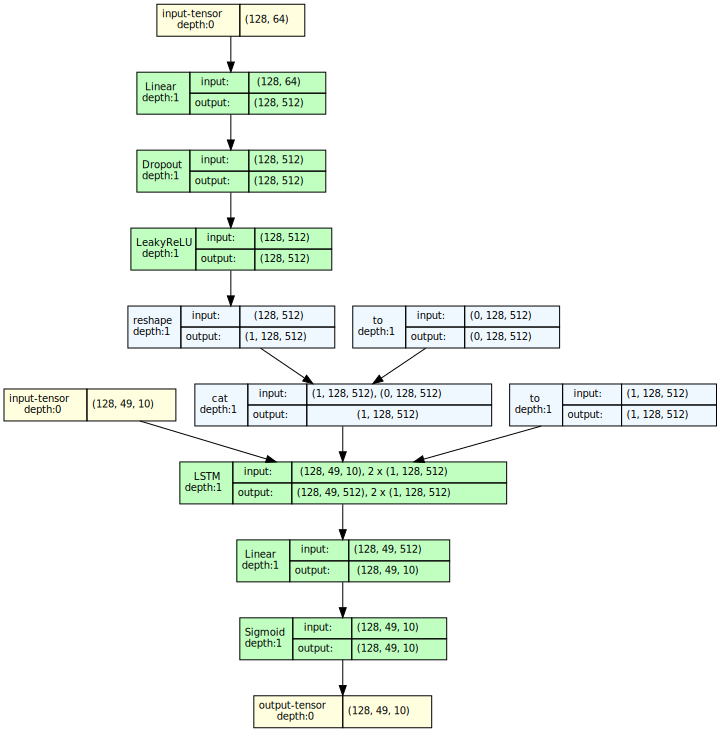

In [ ]:
# Visualize Decoder
from torchview import draw_graph
decoder_graph = draw_graph(decoder,input_size = [(batch_size,sequence_length,input_size),(batch_size,latent_size)],save_graph = True,directory = './Files',filename = 'decoder')
decoder_graph.resize_graph(scale = 2)
decoder_graph.visual_graph

#### Variational Autoencoder

In [ ]:
# Variational Autoencoder Class
import torch.nn as nn
class VAE(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,input_sequence):
        mu,log_var = self.encoder(input_sequence)
        h = self.sample(mu,log_var)
        output_sequence = self.decoder(input_sequence,h)
        return output_sequence,(mu,log_var)

    def sample(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(std)
        z = mu + std*epsilon
        return z

    def generate(self,h,batch_size = 1,sequence_length = 1):
        output_sequence = self.decoder.generate(h,batch_size,sequence_length)
        return output_sequence

    def reconstruct(self,input_sequence):
        mu,log_var = self.encoder(input_sequence)
        h = self.sample(mu,log_var)
        batch_size = input_sequence.shape[0]
        sequence_length = input_sequence.shape[1]
        output_sequence = self.generate(h,batch_size,sequence_length)
        return output_sequence,(mu,log_var)

    def summary(self,batch_size,sequence_length):
        print(summary(self,(batch_size,sequence_length,self.encoder.input_size)))

    def __repr__(self):
        repr = super().__repr__()
        repr = repr.replace('(\n','\n{\n')
        repr = repr.replace('\n)','\n}')
        return repr

def get_sampling_probability(current_step,total_steps,start_prob = 1,end_prob = 0):
    step_ratio = min(1,current_step/total_steps)
    sampling_probability = start_prob - step_ratio*(start_prob - end_prob)
    return sampling_probability

In [ ]:
# Build Variational Autoencoder
vae = VAE(encoder,decoder)
print(vae)
vae.summary(batch_size,sequence_length)

VAE
{
  (encoder): Encoder
  {
    (lstm_layers): LSTM(10,256,batch_first = True,bidirectional = True)
    (linear_layers): ModuleList[]
    (mu_layer): Linear(in_features = 512,out_features = 64,bias = True)
    (var_layer): Linear(in_features = 512,out_features = 64,bias = True)
    (dropout): Dropout(p = 0.3,inplace = False)
    (hidden_activation): LeakyReLU(negative_slope = 0.1)
  }
  (decoder): Decoder
  {
    (linear_layers): ModuleList
    [
      (0): Linear(in_features = 64,out_features = 512,bias = True)
    ]
    (lstm_layers): LSTM(10,512,batch_first = True)
    (output_layer): Linear(in_features = 512,out_features = 10,bias = True)
    (dropout): Dropout(p = 0.3,inplace = False)
    (hidden_activation): LeakyReLU(negative_slope = 0.1)
    (output_activation): Sigmoid()
  }
}
Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 49, 10]             --
├─Encoder: 1-1                           [128, 64]     

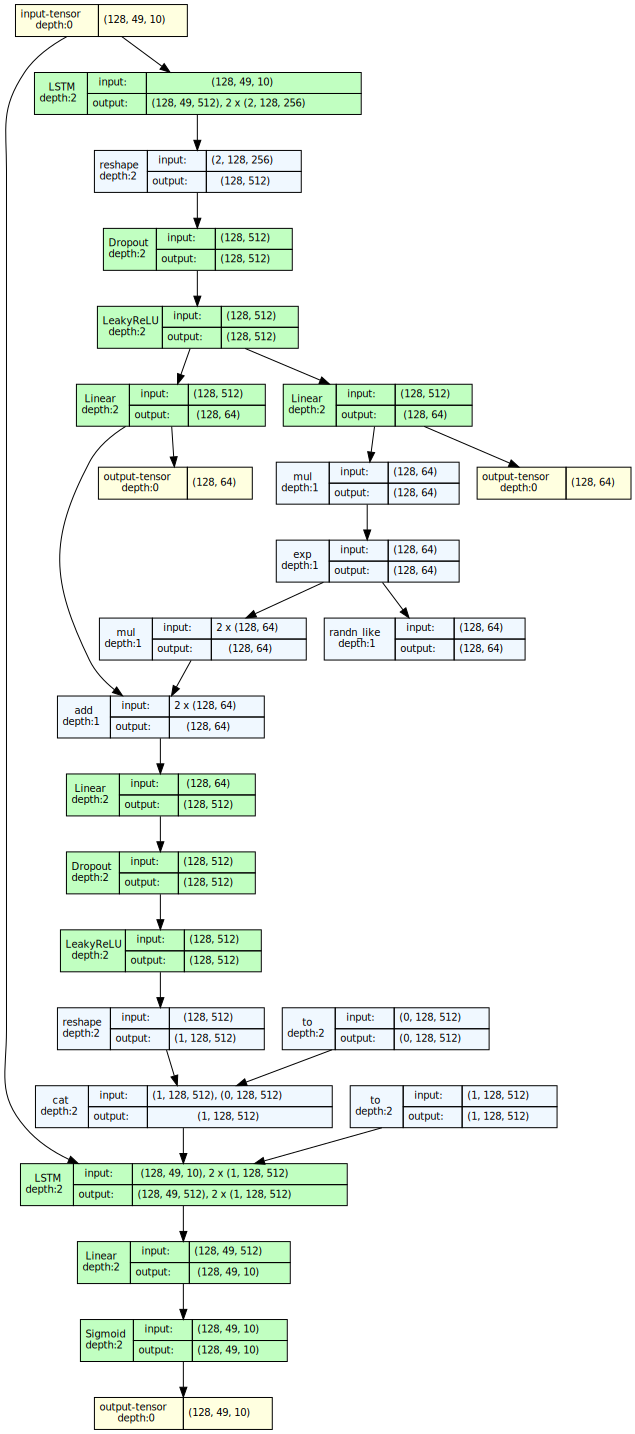

In [ ]:
# Visualize Variational Autoencoder
from torchview import draw_graph
vae_graph = draw_graph(vae,input_size = (batch_size,sequence_length,input_size),save_graph = True,directory = './Files',filename = 'vae')
vae_graph.resize_graph(scale = 2)
vae_graph.visual_graph

## Train Model

In [ ]:
# Define Loss Function
from torch.nn.functional import binary_cross_entropy
def loss_function(x,y,mu,log_var,beta = 1):
    batch_size = x.shape[0]
    BCE = binary_cross_entropy(y,x,reduction = 'sum')/batch_size
    KLD = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())/batch_size
    loss = (BCE + beta*KLD)
    return loss,BCE,KLD

In [ ]:
# Train Model
from torch.optim import Adam
learning_rate = 0.001
optimizer = Adam(vae.parameters(),lr = learning_rate)

num_of_epochs = 300
beta = 0.001*np.ones((num_of_epochs,))

train_loss = np.zeros((num_of_epochs,))
train_BCE = np.zeros((num_of_epochs,))
train_KLD = np.zeros((num_of_epochs,))
train_TP = np.zeros((num_of_epochs,),dtype = int)
train_TN = np.zeros((num_of_epochs,),dtype = int)
train_FP = np.zeros((num_of_epochs,),dtype = int)
train_FN = np.zeros((num_of_epochs,),dtype = int)
train_recall = np.zeros((num_of_epochs,))
train_precision = np.zeros((num_of_epochs,))
train_f1score = np.zeros((num_of_epochs,))
train_jaccard = np.zeros((num_of_epochs,))

valid_loss = np.zeros((num_of_epochs,))
valid_BCE = np.zeros((num_of_epochs,))
valid_KLD = np.zeros((num_of_epochs,))
valid_TP = np.zeros((num_of_epochs,),dtype = int)
valid_TN = np.zeros((num_of_epochs,),dtype = int)
valid_FP = np.zeros((num_of_epochs,),dtype = int)
valid_FN = np.zeros((num_of_epochs,),dtype = int)
valid_recall = np.zeros((num_of_epochs,))
valid_precision = np.zeros((num_of_epochs,))
valid_f1score = np.zeros((num_of_epochs,))
valid_jaccard = np.zeros((num_of_epochs,))

for epoch in range(num_of_epochs):

    vae.train()
    total_loss = 0
    total_BCE = 0
    total_KLD = 0
    total_samples = 0
    for (input_sequence,_,_) in train_loader:

        input_sequence = input_sequence.float().to(vae.device)
        output_sequence,(mu,log_var) = vae(input_sequence)

        input_sequence = input_sequence[:,1:,0:]
        output_sequence = output_sequence[:,:-1,0:]

        loss = loss_function(input_sequence,output_sequence,mu,log_var,beta[epoch])
        total_loss += loss[0].item()
        total_BCE += loss[1].item()
        total_KLD += loss[2].item()

        optimizer.zero_grad()
        loss[0].backward()
        optimizer.step()

        total_samples += input_sequence.shape[0]
        train_loss[epoch] = total_loss/total_samples
        train_BCE[epoch] = total_BCE/total_samples
        train_KLD[epoch] = total_KLD/total_samples

        predictions = (output_sequence > 0.5).bool()
        targets = input_sequence.bool()
        train_TP[epoch] += torch.sum((predictions & targets).int()).item()
        train_TN[epoch] += torch.sum((~predictions & ~targets).int()).item()
        train_FP[epoch] += torch.sum((predictions & ~targets).int()).item()
        train_FN[epoch] += torch.sum((~predictions & targets).int()).item()

    train_recall[epoch] = train_TP[epoch] / (train_TP[epoch] + train_FN[epoch])
    train_precision[epoch] = train_TP[epoch] / (train_TP[epoch] + train_FP[epoch])
    train_f1score[epoch] = 2*train_recall[epoch]*train_precision[epoch] / (train_recall[epoch] + train_precision[epoch])
    train_jaccard[epoch] = train_TP[epoch] / (train_TP[epoch] + train_FP[epoch] + train_FN[epoch])

    vae.eval()
    total_loss = 0
    total_BCE = 0
    total_KLD = 0
    total_samples = 0
    for (input_sequence,_,_) in valid_loader:

        input_sequence = input_sequence.float().to(vae.device)
        output_sequence,(mu,log_var) = vae.reconstruct(input_sequence)

        input_sequence = input_sequence[:,1:,0:]
        output_sequence = output_sequence[:,:-1,0:]

        loss = loss_function(input_sequence,output_sequence,mu,log_var,beta[epoch])
        total_loss += loss[0].item()
        total_BCE += loss[1].item()
        total_KLD += loss[2].item()

        total_samples += input_sequence.shape[0]
        valid_loss[epoch] = total_loss/total_samples
        valid_BCE[epoch] = total_BCE/total_samples
        valid_KLD[epoch] = total_KLD/total_samples

        predictions = (output_sequence > 0.5).bool()
        targets = input_sequence.bool()
        valid_TP[epoch] += torch.sum((predictions & targets).int()).item()
        valid_TN[epoch] += torch.sum((~predictions & ~targets).int()).item()
        valid_FP[epoch] += torch.sum((predictions & ~targets).int()).item()
        valid_FN[epoch] += torch.sum((~predictions & targets).int()).item()

    valid_recall[epoch] = valid_TP[epoch] / (valid_TP[epoch] + valid_FN[epoch])
    valid_precision[epoch] = valid_TP[epoch] / (valid_TP[epoch] + valid_FP[epoch])
    valid_f1score[epoch] = 2*valid_recall[epoch]*valid_precision[epoch] / (valid_recall[epoch] + valid_precision[epoch])
    valid_jaccard[epoch] = valid_TP[epoch] / (valid_TP[epoch] + valid_FP[epoch] + valid_FN[epoch])

    print(f"Epoch [{epoch + 1}/{num_of_epochs}] {' '*(len(str(num_of_epochs)) - len(str(epoch + 1)))}|| "
          f"Training: Loss -> {train_loss[epoch]:.3f} | BCE -> {train_BCE[epoch]:.3f} | KLD -> {train_KLD[epoch]:.6f} | TP -> {train_TP[epoch]} | TN -> {train_TN[epoch]} | FP -> {train_FP[epoch]} | FN -> {train_FN[epoch]} | Recall -> {train_recall[epoch]:.3f} | Precision -> {train_precision[epoch]:.3f} | F1-Score -> {train_f1score[epoch]:.3f} | Jaccard Index -> {train_jaccard[epoch]:.3f} || "
          f"Validation: Loss -> {valid_loss[epoch]:.3f} | BCE -> {valid_BCE[epoch]:.3f} | KLD -> {valid_KLD[epoch]:.6f} | TP -> {valid_TP[epoch]} | TN -> {valid_TN[epoch]} | FP -> {valid_FP[epoch]} | FN -> {valid_FN[epoch]} | Recall -> {valid_recall[epoch]:.3f} | Precision -> {valid_precision[epoch]:.3f} | F1-Score -> {valid_f1score[epoch]:.3f} | Jaccard Index -> {valid_jaccard[epoch]:.3f}")

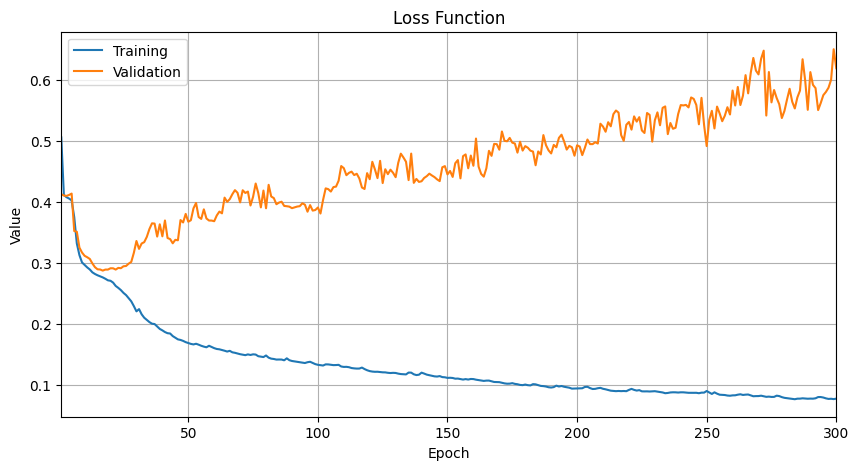

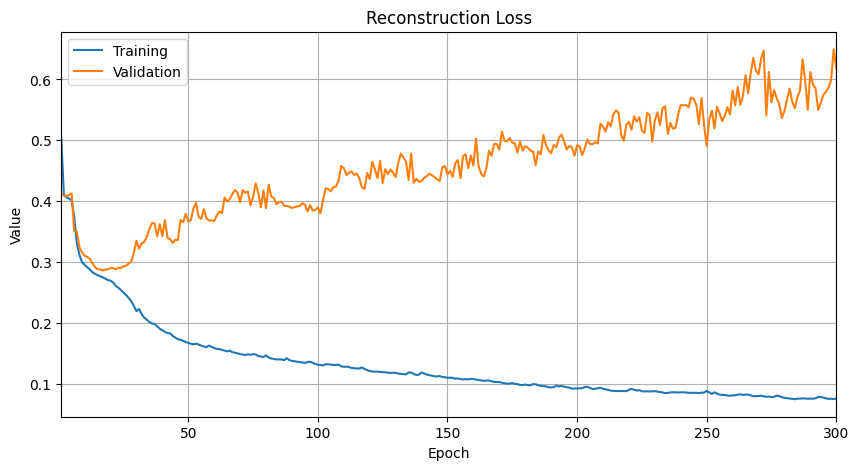

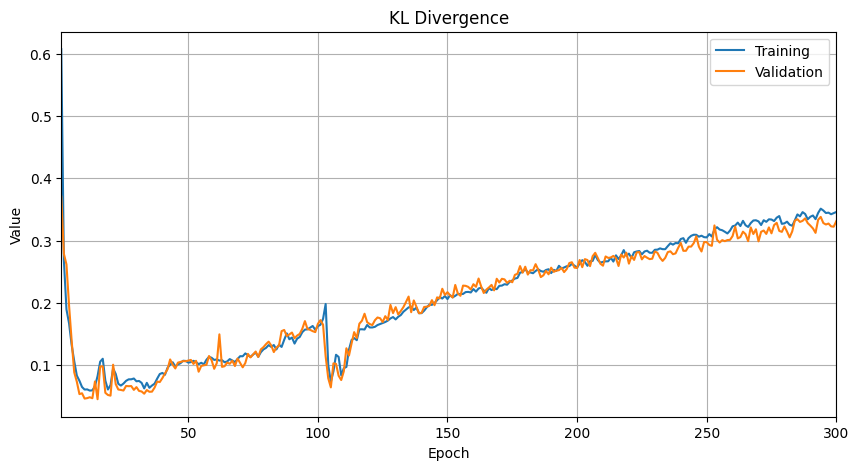

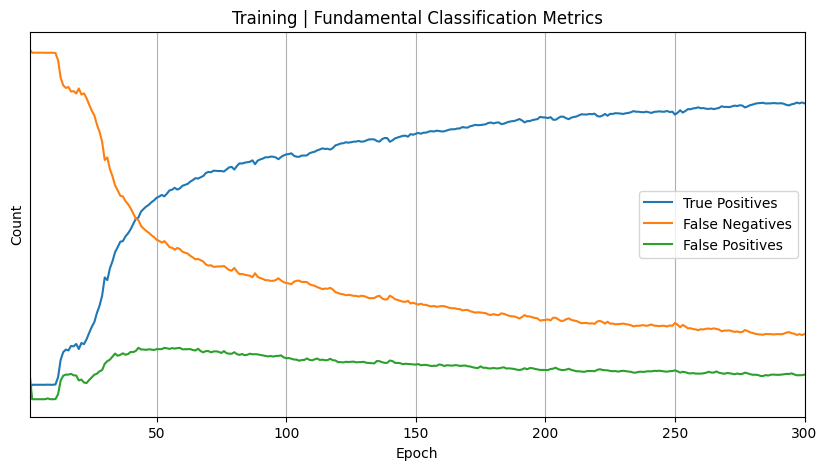

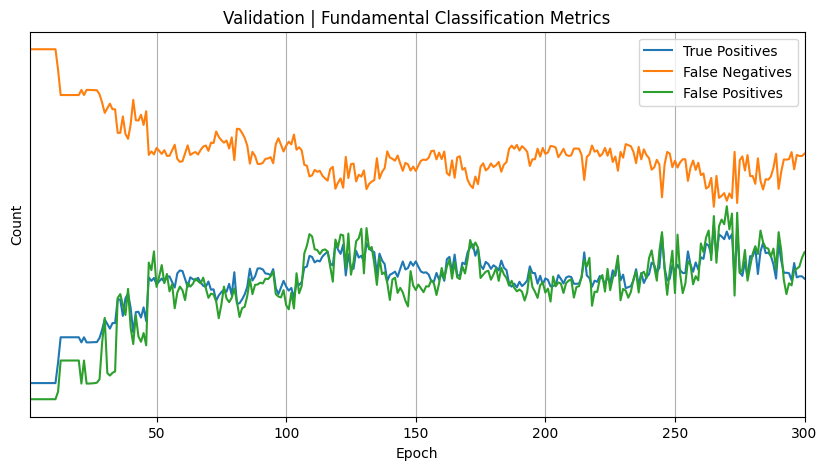

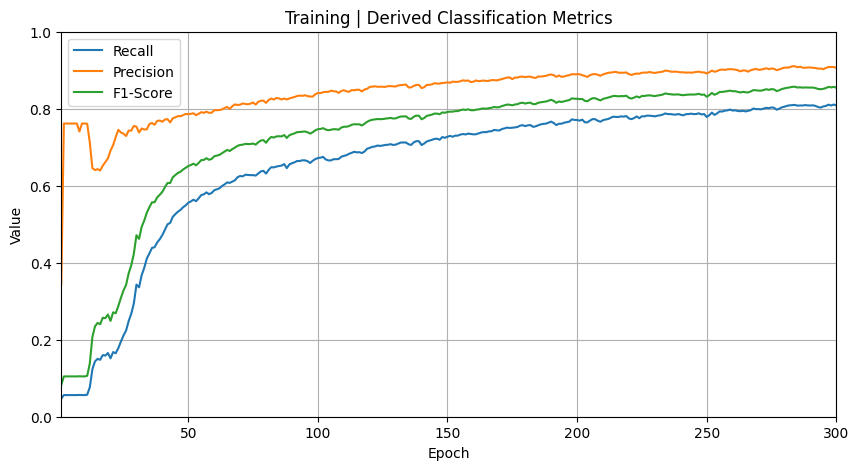

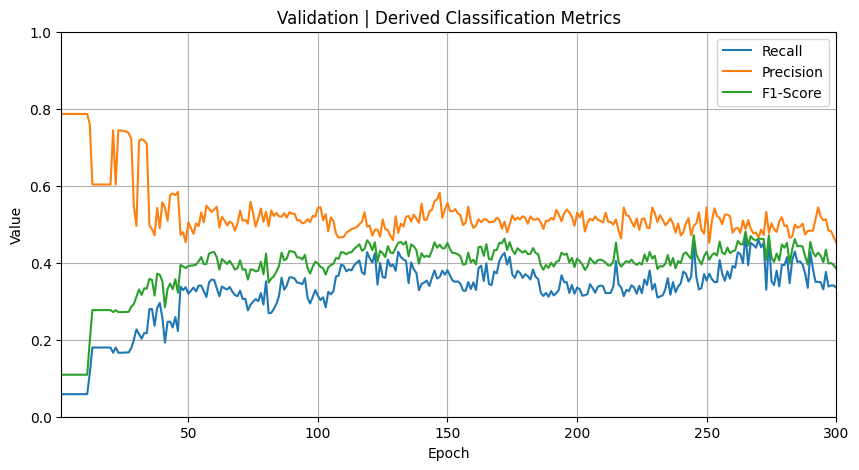

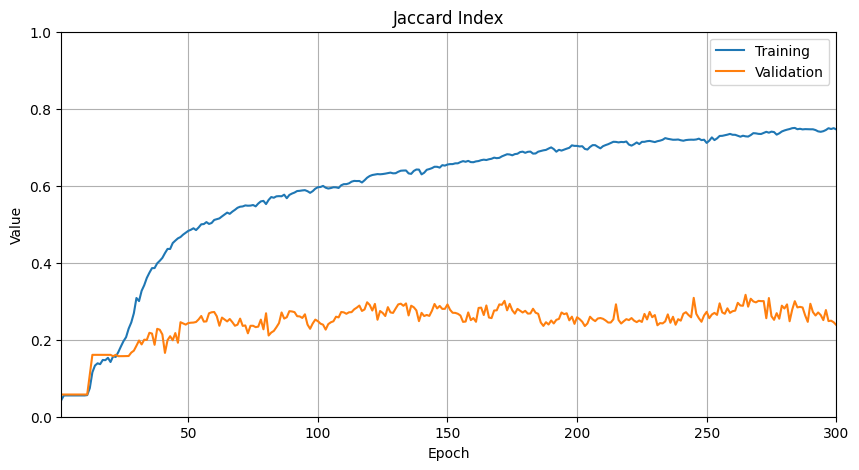

In [ ]:
# Plot Training History
history = {'train_loss' : train_loss,
            'train_BCE' : train_BCE,
            'train_KLD' : train_KLD,
             'train_TP' : train_TP,
             'train_TN' : train_TN,
             'train_FP' : train_FP,
             'train_FN' : train_FN,
         'train_recall' : train_recall,
      'train_precision' : train_precision,
        'train_f1score' : train_f1score,
        'train_jaccard' : train_jaccard,
           'valid_loss' : valid_loss,
            'valid_BCE' : valid_BCE,
            'valid_KLD' : valid_KLD,
             'valid_TP' : valid_TP,
             'valid_TN' : valid_TN,
             'valid_FP' : valid_FP,
             'valid_FN' : valid_FN,
         'valid_recall' : valid_recall,
      'valid_precision' : valid_precision,
        'valid_f1score' : valid_f1score,
        'valid_jaccard' : valid_jaccard}
epochs = np.arange(1,num_of_epochs + 1)

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_loss'],label = "Training")
plt.plot(epochs,history['valid_loss'],label = "Validation")
plt.xlim((1,num_of_epochs))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Loss Function")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_BCE'],label = "Training")
plt.plot(epochs,history['valid_BCE'],label = "Validation")
plt.xlim((1,num_of_epochs))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Reconstruction Loss")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_KLD'],label = "Training")
plt.plot(epochs,history['valid_KLD'],label = "Validation")
plt.xlim((1,num_of_epochs))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("KL Divergence")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_TP'],label = "True Positives")
plt.plot(epochs,history['train_FN'],label = "False Negatives")
plt.plot(epochs,history['train_FP'],label = "False Positives")
plt.xlim((1,num_of_epochs))
plt.yticks([])
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Training | Fundamental Classification Metrics")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['valid_TP'],label = "True Positives")
plt.plot(epochs,history['valid_FN'],label = "False Negatives")
plt.plot(epochs,history['valid_FP'],label = "False Positives")
plt.xlim((1,num_of_epochs))
plt.yticks([])
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Validation | Fundamental Classification Metrics")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_recall'],label = "Recall")
plt.plot(epochs,history['train_precision'],label = "Precision")
plt.plot(epochs,history['train_f1score'],label = "F1-Score")
plt.xlim((1,num_of_epochs))
plt.ylim((0,1))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training | Derived Classification Metrics")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['valid_recall'],label = "Recall")
plt.plot(epochs,history['valid_precision'],label = "Precision")
plt.plot(epochs,history['valid_f1score'],label = "F1-Score")
plt.xlim((1,num_of_epochs))
plt.ylim((0,1))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Validation | Derived Classification Metrics")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(epochs,history['train_jaccard'],label = "Training")
plt.plot(epochs,history['valid_jaccard'],label = "Validation")
plt.xlim((1,num_of_epochs))
plt.ylim((0,1))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Jaccard Index")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

## Test Model

In [ ]:
# Test Model
test_TP = 0
test_TN = 0
test_FP = 0
test_FN = 0

vae.eval()
total_loss = 0
total_BCE = 0
total_KLD = 0
total_samples = 0
for (input_sequence,_,_) in test_loader:

    input_sequence = input_sequence.float().to(vae.device)
    output_sequence,(mu,log_var) = vae.reconstruct(input_sequence)

    input_sequence = input_sequence[:,1:,1:]
    output_sequence = output_sequence[:,:-1,1:]

    loss = loss_function(input_sequence,output_sequence,mu,log_var)
    total_loss += loss[0].item()
    total_BCE += loss[1].item()
    total_KLD += loss[2].item()

    total_samples += input_sequence.shape[0]
    test_loss = total_loss/total_samples
    test_BCE = total_BCE/total_samples
    test_KLD = total_KLD/total_samples

    predictions = (output_sequence > 0.5).bool()
    targets = input_sequence.bool()
    test_TP += torch.sum((predictions & targets).int()).item()
    test_TN += torch.sum((~predictions & ~targets).int()).item()
    test_FP += torch.sum((predictions & ~targets).int()).item()
    test_FN += torch.sum((~predictions & targets).int()).item()

test_recall = test_TP / (test_TP + test_FN)
test_precision = test_TP / (test_TP + test_FP)
test_f1score = 2*test_recall*test_precision / (test_recall + test_precision)
test_jaccard = test_TP / (test_TP + test_FP + test_FN)

print('Testing:')
print(f'Loss          -> {test_loss:.3f}')
print(f'BCE           -> {test_BCE:.3f}')
print(f'KLD           -> {test_KLD:.3f}')
print(f'TP            -> {test_TP}')
print(f'TN            -> {test_TN}')
print(f'FP            -> {test_FP}')
print(f'FN            -> {test_FN}')
print(f'Recall        -> {test_recall:.3f}')
print(f'Precision     -> {test_precision:.3f}')
print(f'F1-Score      -> {test_f1score:.3f}')
print(f'Jaccard Index -> {test_jaccard:.3f}')

Testing:
Loss          -> 0.496
BCE           -> 0.359
KLD           -> 0.137
TP            -> 9012
TN            -> 900817
FP            -> 6638
FN            -> 20109
Recall        -> 0.309
Precision     -> 0.576
F1-Score      -> 0.403
Jaccard Index -> 0.252


In [ ]:
# List Testing Tracks
unique_ids,counts = np.unique(test_set[:][1],return_counts = True)
print("ID BARS")
for (id,bars) in zip(unique_ids,counts):
    print(id,bars)

ID BARS
16 286
22 160
74 161
77 252
90 140
95 232
103 179
106 274
110 108
120 99
125 202
150 75


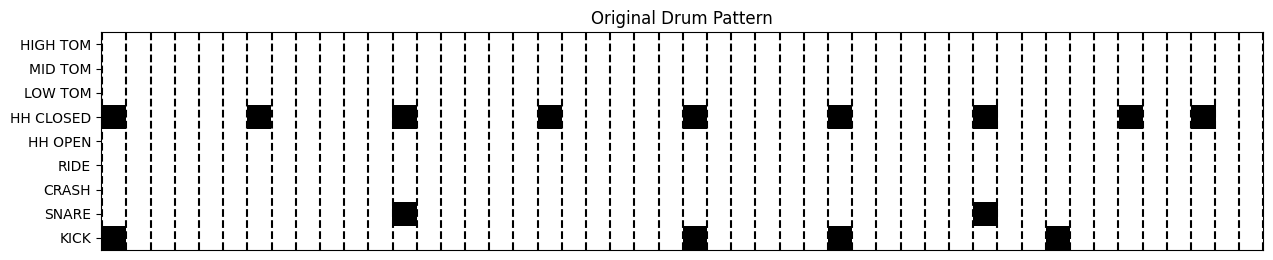

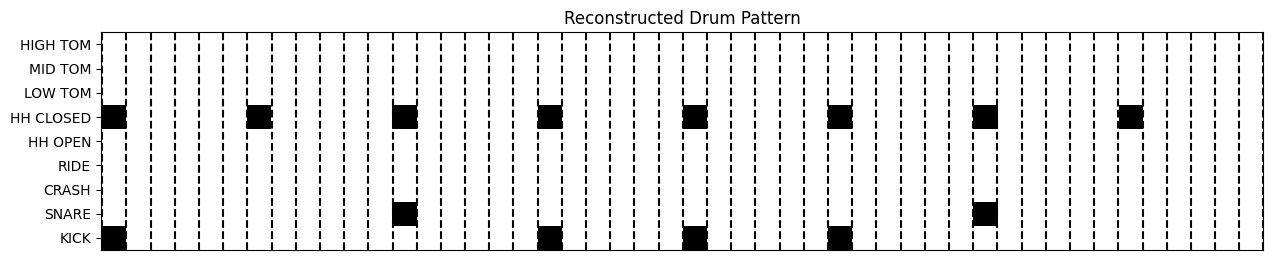

In [ ]:
# Reconstruct Selected Pattern
id_selection = 125
bar_selection = 2
invalid_selection = True

for (onsets,id,bar) in test_set:
    if id == id_selection and bar == bar_selection:
        invalid_selection = False
        input_sequence = torch.tensor(onsets)
        input_sequence = torch.unsqueeze(input_sequence,0).float().to(vae.device)
        output_sequence = vae.reconstruct(input_sequence)[0]
        output_sequence = (output_sequence > 0.5).float()
        input_sequence = torch.squeeze(input_sequence[:,1:,1:]).detach().cpu().numpy().T
        output_sequence = torch.squeeze(output_sequence[:,:-1,1:]).detach().cpu().numpy().T

        plt.figure(figsize = (15,3))
        plt.imshow(input_sequence,cmap = 'binary',origin = 'lower')
        plt.vlines(np.arange(sequence_length)-0.5,plt.ylim()[0],plt.ylim()[1],color = 'k',linestyle = '--')
        plt.xlim(left = -0.55)
        plt.xticks([])
        plt.yticks(np.arange(len(dataset.parts)),dataset.parts)
        plt.title("Original Drum Pattern")
        plt.show()

        plt.figure(figsize = (15,3))
        plt.imshow(output_sequence,cmap = 'binary',origin = 'lower')
        plt.vlines(np.arange(sequence_length)-0.5,plt.ylim()[0],plt.ylim()[1],color = 'k',linestyle = '--')
        plt.xlim(left = -0.55)
        plt.xticks([])
        plt.yticks(np.arange(len(dataset.parts)),dataset.parts)
        plt.title("Reconstructed Drum Pattern")
        plt.show()

        break

if(invalid_selection):
    print("Invalid ID/Bar")

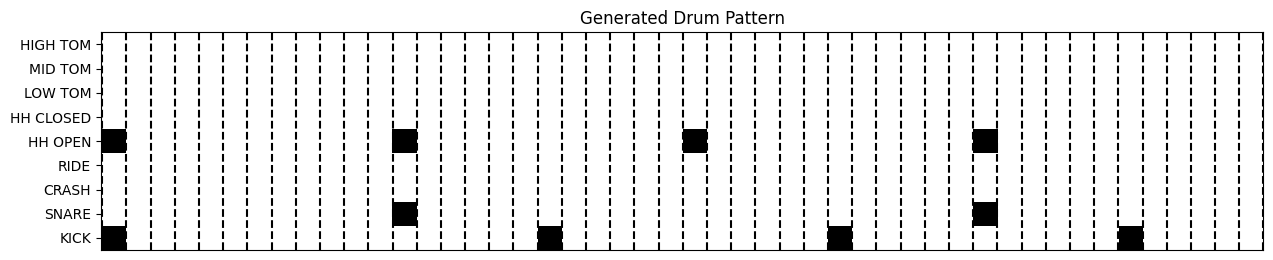

In [ ]:
# Generate Random Pattern
z = torch.randn((1,latent_size)).to(vae.device)
output_sequence = vae.generate(z,sequence_length = sequence_length)
output_sequence = (output_sequence > 0.5).float()
output_sequence = torch.squeeze(output_sequence[:,:-1,1:]).detach().cpu().numpy().T
plt.figure(figsize = (15,3))
plt.imshow(output_sequence,cmap = 'binary',origin = 'lower')
plt.vlines(np.arange(sequence_length)-0.5,plt.ylim()[0],plt.ylim()[1],color = 'k',linestyle = '--')
plt.xlim(left = -0.55)
plt.xticks([])
plt.yticks(np.arange(len(dataset.parts)),dataset.parts)
plt.title("Generated Drum Pattern")
plt.show()